# TinyML - Long Short-Term Memory (LSTM) 

#### Federal University of Rio Grande do Norte

#### Name: Thommas Kevin Sales Flores

## 0. Install the libraries listed in the requirements.txt file

In [32]:
#!pip install -r requirements.txt

## 1. Importing libraries

In [33]:
from sklearn.model_selection import train_test_split
from eloquent_tensorflow import convert_model
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

The "Vehicle Attributes and Emissions Dataset" contains comprehensive information on various vehicles manufactured in the year 2000. It includes details such as make, model, vehicle class, engine size, cylinder count, transmission type, and fuel type. Additionally, the dataset provides ranges for fuel consumption and CO2 emissions, offering insights into the environmental impact of each vehicle. The dataset encompasses a wide range of vehicle types, from compact to mid-size, and includes both conventional and high-performance models. With this information, analysts and researchers can study trends in vehicle characteristics, fuel efficiency, and emissions . This dataset serves as a valuable resource for understanding the automotive landscape and informing discussions on environmental sustainability and transportation policies.

link: https://www.kaggle.com/datasets/krupadharamshi/fuelconsumption/data

In [34]:
df = pd.read_csv('./data/FuelConsumption.csv')
df.head()

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,10.5,216
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,9.8,205
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,13.7,265
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,15.0,301
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,11.4,230


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              639 non-null    int64  
 1   MAKE              639 non-null    object 
 2   MODEL             639 non-null    object 
 3   VEHICLE CLASS     639 non-null    object 
 4   ENGINE SIZE       639 non-null    float64
 5   CYLINDERS         639 non-null    int64  
 6   TRANSMISSION      639 non-null    object 
 7   FUEL              639 non-null    object 
 8   FUEL CONSUMPTION  639 non-null    float64
 9   COEMISSIONS       639 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 50.0+ KB


In [36]:
df.describe()

,Year,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,COEMISSIONS
count,639.0,639.000000,639.000000,639.000000,639.000000
mean,2000.0,3.265728,5.805947,14.713615,296.809077
std,0.0,1.231012,1.625588,3.307044,65.504178
min,2000.0,1.000000,3.000000,4.900000,104.000000
25%,2000.0,2.200000,4.000000,12.500000,253.000000
50%,2000.0,3.000000,6.000000,14.400000,288.000000
75%,2000.0,4.300000,6.000000,16.600000,343.000000
max,2000.0,8.000000,12.000000,30.200000,582.000000


## 3. Clean Data

In [37]:
# 1. Removing rows with missing values
df.dropna(inplace=True)
# 2. Removing duplicates if any
df.drop_duplicates(inplace=True)
# Display the dataframe after cleaning
df.describe()

,Year,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,COEMISSIONS
count,638.0,638.000000,638.000000,638.000000,638.000000
mean,2000.0,3.264577,5.802508,14.705956,296.642633
std,0.0,1.231634,1.624535,3.303962,65.420203
min,2000.0,1.000000,3.000000,4.900000,104.000000
25%,2000.0,2.200000,4.000000,12.500000,253.000000
50%,2000.0,3.000000,6.000000,14.400000,288.000000
75%,2000.0,4.300000,6.000000,16.600000,343.000000
max,2000.0,8.000000,12.000000,30.200000,582.000000


## 4. Exploratory Data Analysis

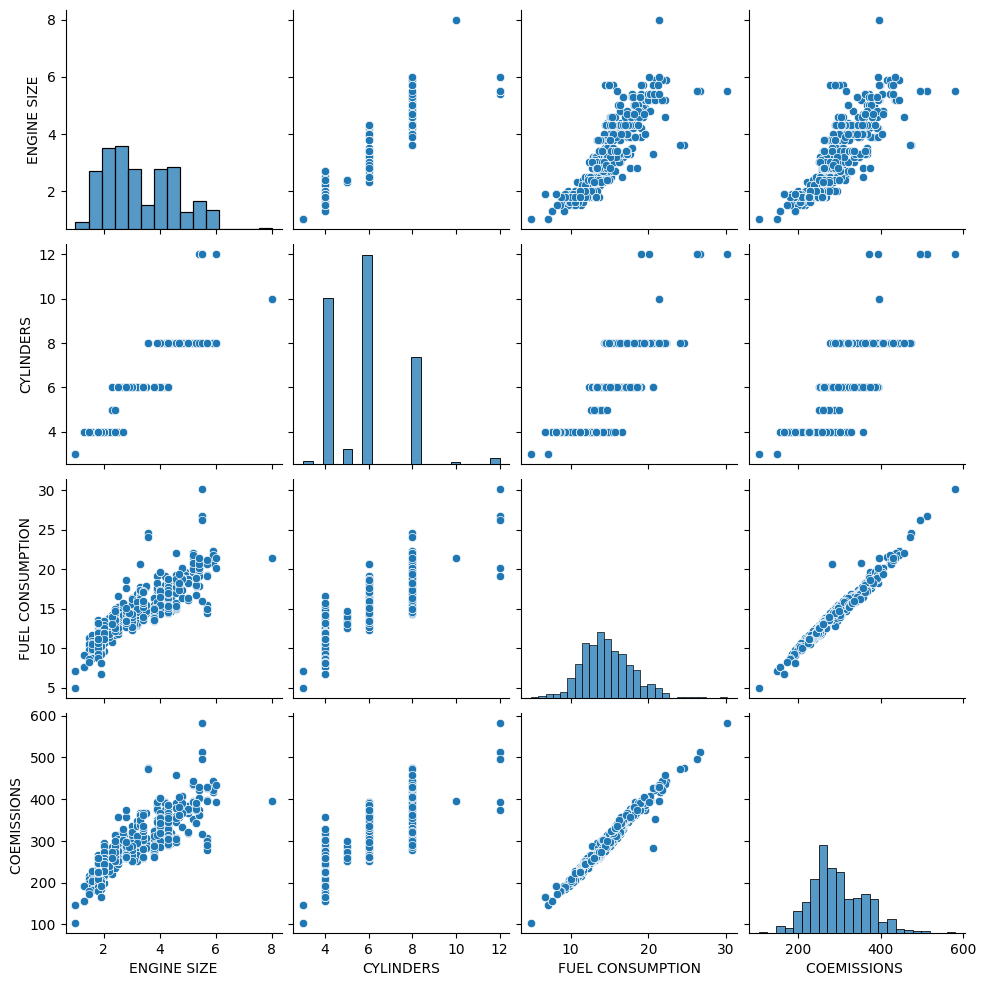

In [38]:
sns.pairplot(df[['ENGINE SIZE','CYLINDERS','FUEL CONSUMPTION','COEMISSIONS ']])
plt.savefig('.\\figures\\pairplot.png', dpi=300, bbox_inches='tight')

In [39]:
corr = df[['ENGINE SIZE','CYLINDERS','FUEL CONSUMPTION','COEMISSIONS ']].corr('spearman')

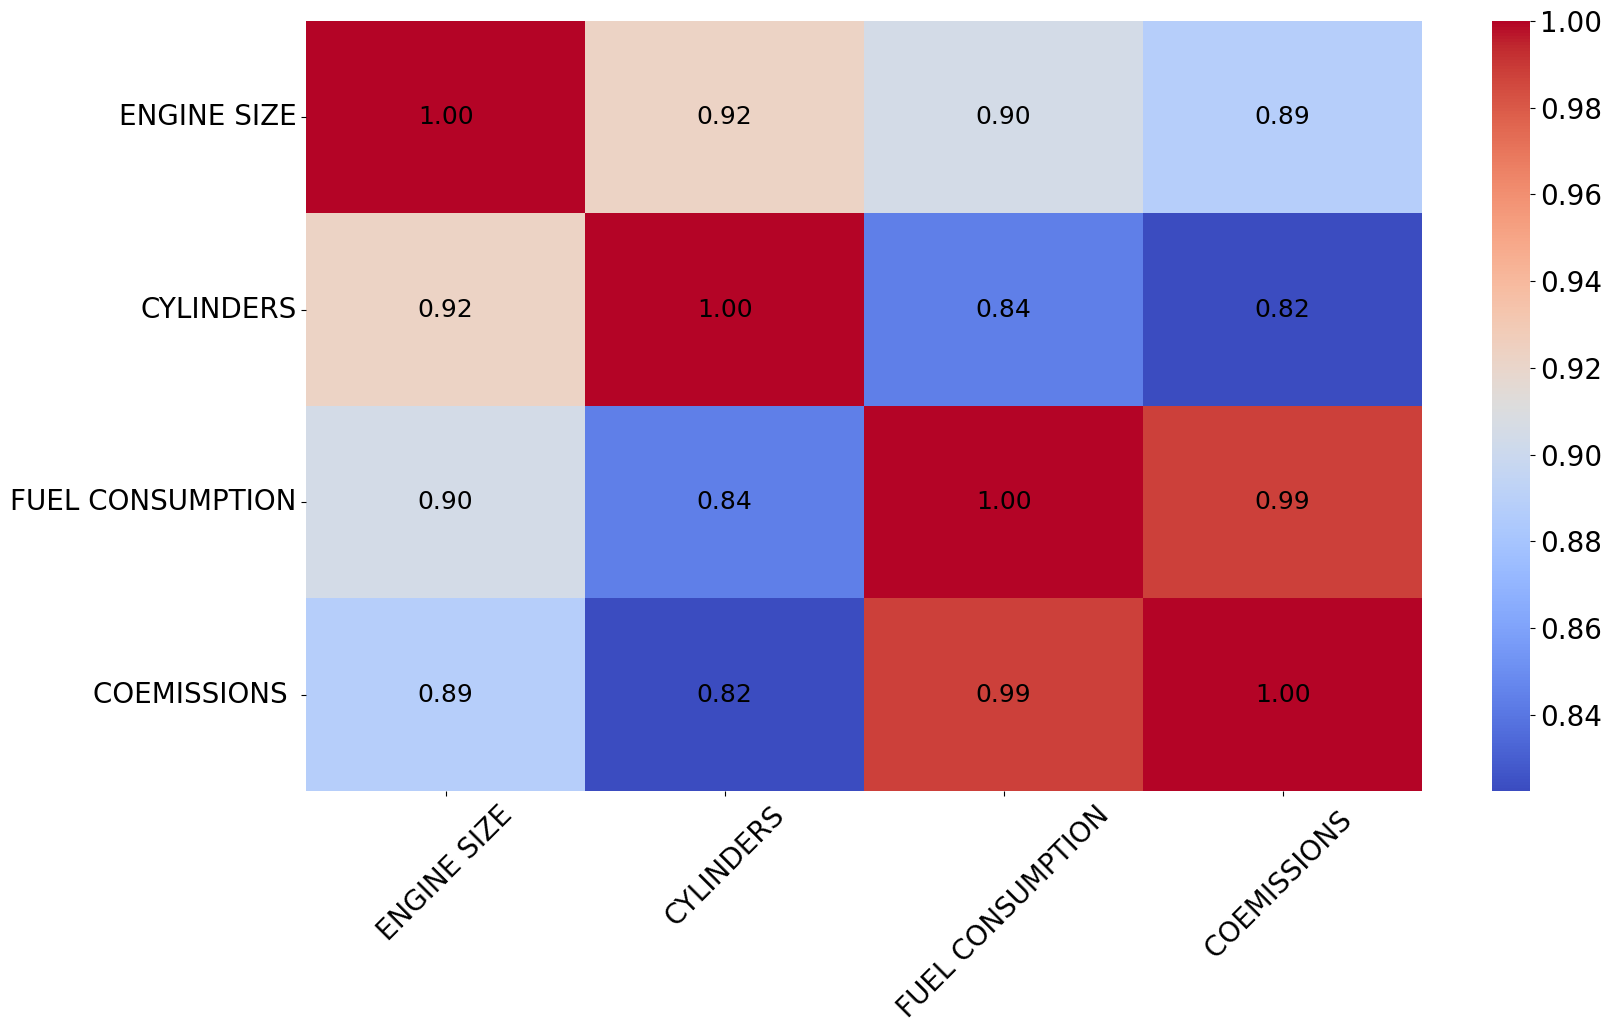

In [40]:
# Adjusting the size of the figure
plt.figure(figsize=(18,10))
# Your existing code for generating the heatmap
heatmap = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')
# Adding values to the heatmap
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j + 0.5, i + 0.5, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=18)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20, rotation=0)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)

plt.savefig('.\\figures\\heatmap.png', dpi=300, bbox_inches='tight')

# Display the heatmap
plt.show()

## 5. Splitting the data

In [41]:
X=df[['ENGINE SIZE','CYLINDERS', 'COEMISSIONS ']]
y=df[['FUEL CONSUMPTION']]

In [42]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 6. Long Short-Term Memory (LSTM) 

### 6.1 Create the model

In [44]:
def instantiate_lstm_for_regression(input_shape, output_shape):
  model = tf.keras.Sequential()
  model.add(layers.Input(shape=input_shape, batch_size=1))
  model.add(layers.LSTM(12, unroll=False, return_sequences=True))
  model.add(layers.LSTM(12, unroll=False))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(output_shape, activation='linear'))
  model.compile(optimizer='adamax', loss='mae', metrics=['mae'])

  return model

In [45]:
model = instantiate_lstm_for_regression(input_shape = (3,1), output_shape = 1)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 3, 12)                672       
                                                                 
 lstm_3 (LSTM)               (1, 12)                   1200      
                                                                 
 dense_2 (Dense)             (1, 32)                   416       
                                                                 
 dense_3 (Dense)             (1, 1)                    33        
                                                                 
Total params: 2321 (9.07 KB)
Trainable params: 2321 (9.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


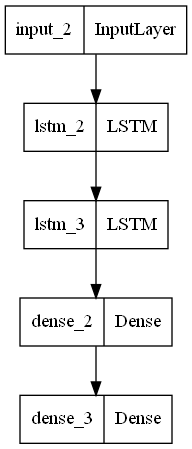

In [46]:
plot_model(model, to_file='./figures/model.png')

### 6.2 Train Model 

In [47]:
history = model.fit(X_train, y_train,  validation_split=0.2, epochs=300)

Epoch 1/300
12/12 [==============================] - 4s 70ms/step - loss: 14.5522 - mae: 14.5522 - val_loss: 14.1713 - val_mae: 14.1713
Epoch 2/300
12/12 [==============================] - 0s 7ms/step - loss: 14.3902 - mae: 14.3902 - val_loss: 14.0012 - val_mae: 14.0012
Epoch 3/300
12/12 [==============================] - 0s 9ms/step - loss: 14.2109 - mae: 14.2109 - val_loss: 13.8112 - val_mae: 13.8112
Epoch 4/300
12/12 [==============================] - 0s 7ms/step - loss: 14.0090 - mae: 14.0090 - val_loss: 13.5998 - val_mae: 13.5998
Epoch 5/300
12/12 [==============================] - 0s 6ms/step - loss: 13.7886 - mae: 13.7886 - val_loss: 13.3638 - val_mae: 13.3638
Epoch 6/300
12/12 [==============================] - 0s 9ms/step - loss: 13.5321 - mae: 13.5321 - val_loss: 13.0780 - val_mae: 13.0780
Epoch 7/300
12/12 [==============================] - 0s 8ms/step - loss: 13.2199 - mae: 13.2199 - val_loss: 12.7295 - val_mae: 12.7295
Epoch 8/300
12/12 [==============================] - 0

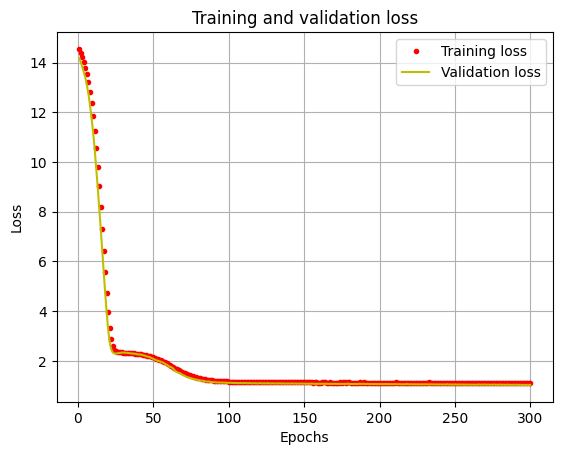

In [48]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('.\\figures\\history_traing.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Model evaluation

In [49]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.3676 - mae: 1.3676


[1.3675765991210938, 1.3675765991210938]

In [50]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


### 7.1 Evaluating the model with train data

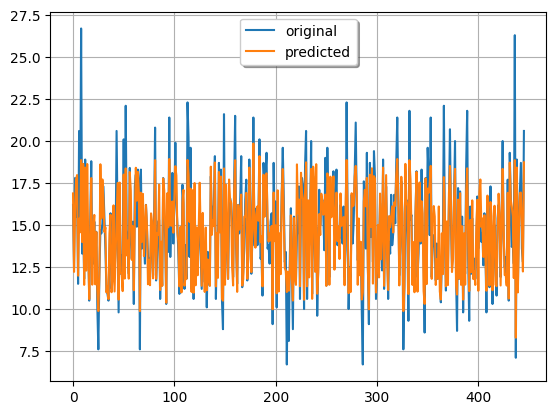

In [51]:
plt.plot(y_train, label="original")
plt.plot(y_train_pred, label="predicted")
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid()
plt.show()

### 7.2 Evaluating the model with test data

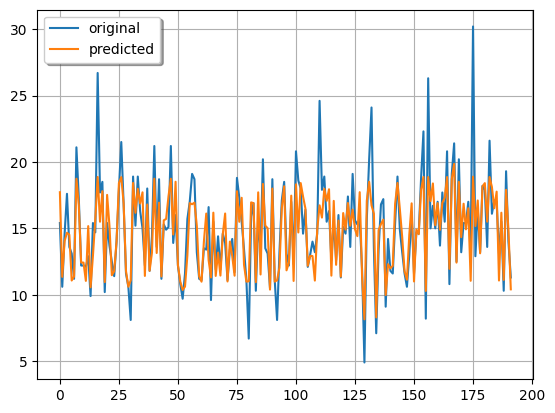

In [52]:
plt.plot(y_test, label="original")
plt.plot(y_test_pred, label="predicted")
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid()
plt.show()

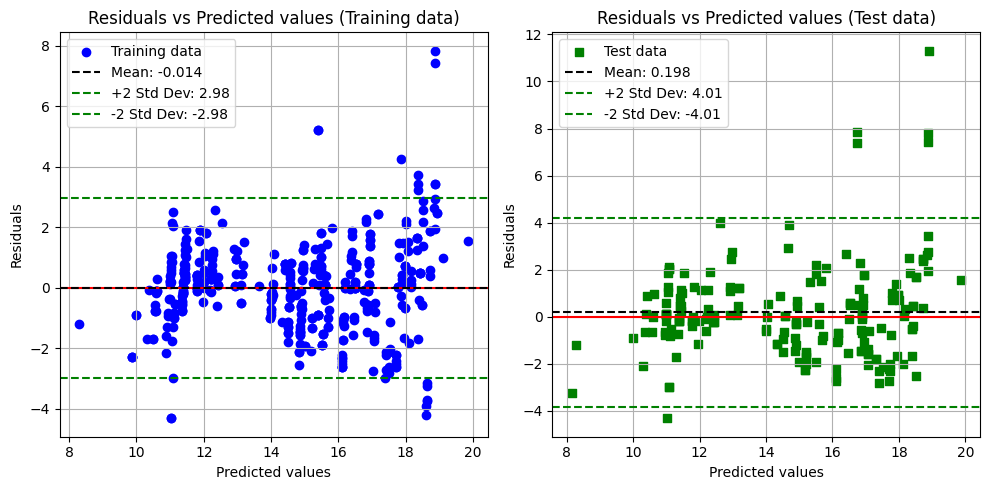

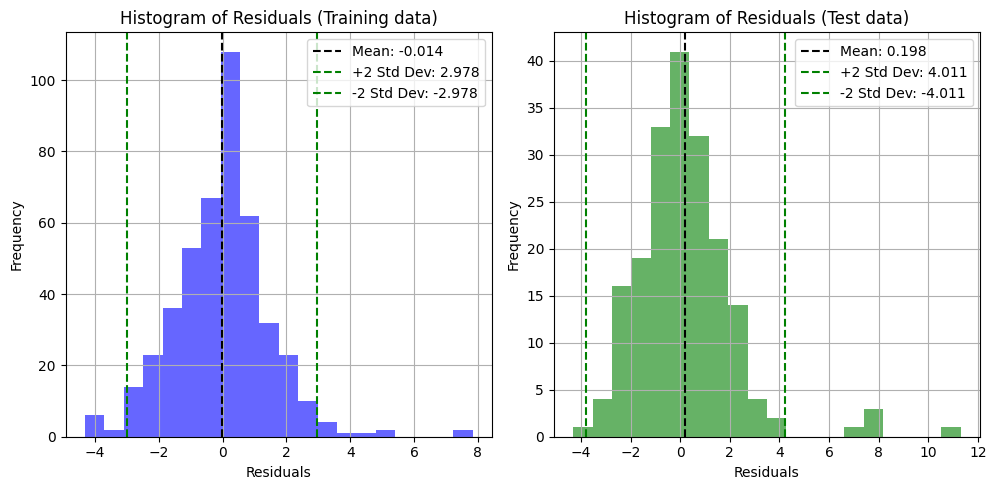

In [53]:
# Calculate residuals
train_residuals = y_train.tolist() - y_train_pred
# Calculate mean and standard deviation of residuals
train_residuals_mean = np.mean(train_residuals)
train_residuals_std = np.std(train_residuals)
# Calculate residuals
test_residuals = y_test.tolist() - y_test_pred
# Calculate mean and standard deviation of residuals
test_residuals_mean = np.mean(test_residuals)
test_residuals_std = np.std(test_residuals)

# Plot residuals
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, c='blue', marker='o', label=f'Training data')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=train_residuals_mean, color='k', linestyle='--', label=f'Mean: {train_residuals_mean:.3f}')
plt.axhline(y=train_residuals_mean + 2 * train_residuals_std, color='g', linestyle='--', label=f'+2 Std Dev: {2*train_residuals_std:.2f}')
plt.axhline(y=train_residuals_mean - 2 * train_residuals_std, color='g', linestyle='--', label=f'-2 Std Dev: {-2*train_residuals_std:.2f}')  
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Training data)')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, c='green', marker='s', label=f'Test data')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=test_residuals_mean, color='k', linestyle='--', label=f'Mean: {test_residuals_mean:.3f}')
plt.axhline(y=test_residuals_mean + 2 * test_residuals_std, color='g', linestyle='--', label=f'+2 Std Dev: {2*test_residuals_std:.2f}')
plt.axhline(y=test_residuals_mean - 2 * test_residuals_std, color='g', linestyle='--', label=f'-2 Std Dev: {-2*test_residuals_std:.2f}')  
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Test data)')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()



# Check for normality
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_residuals, bins=20, color='blue', alpha=0.6)
plt.title('Histogram of Residuals (Training data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(x=train_residuals_mean, color='k', linestyle='--', label=f'Mean: {train_residuals_mean:.3f}')
plt.axvline(x=train_residuals_mean + 2 * train_residuals_std, color='g', linestyle='--', label=f'+2 Std Dev: {2*train_residuals_std:.3f}')
plt.axvline(x=train_residuals_mean - 2 * train_residuals_std, color='g', linestyle='--', label=f'-2 Std Dev: {-2*train_residuals_std:.3f}')  
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(test_residuals, bins=20, color='green', alpha=0.6)
plt.title('Histogram of Residuals (Test data)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(x=test_residuals_mean, color='k', linestyle='--', label=f'Mean: {test_residuals_mean:.3f}')
plt.axvline(x=test_residuals_mean + 2 * test_residuals_std, color='g', linestyle='--', label=f'+2 Std Dev: {2*test_residuals_std:.3f}')
plt.axvline(x=test_residuals_mean - 2 * test_residuals_std, color='g', linestyle='--', label=f'-2 Std Dev: {-2*test_residuals_std:.3f}')  
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Obtaining the model to be implemented in the microcontroller

In [54]:
# Example usage of convert_model
code = convert_model(model)

INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpgds78fzs\assets


INFO:tensorflow:Assets written to: C:\Users\Thommas\AppData\Local\Temp\tmpgds78fzs\assets


In [55]:
print(code)

#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

// automatically configure network
#define TF_NUM_INPUTS 3
#define TF_NUM_OUTPUTS 1
#define TF_NUM_OPS 21

/**
 * Call this function to register the ops
 * that have been detected
 */
template<class TF>
void registerNetworkOps(TF& nn) {
    nn.resolver.AddMaximum();
    nn.resolver.AddTranspose();
    nn.resolver.AddConcatenation();
    nn.resolver.AddPack();
    nn.resolver.AddMinimum();
    nn.resolver.AddSplit();
    nn.resolver.AddWhile();
    nn.resolver.AddStridedSlice();
    nn.resolver.AddFullyConnected();
    nn.resolver.AddUnidirectionalSequenceLSTM();
    nn.resolver.AddFill();
    nn.resolver.AddSoftmax();
    nn.resolver.AddSlice();
    nn.resolver.AddTanh();
    nn.resolver.AddSha

## 9. Saves the template in a .h file

In [56]:
with open('./LSTM/model.h', 'w') as file:
    file.write(code)